For the geographic sanitary regions: https://analisi.transparenciacatalunya.cat/Salut/Regions-sanit-ries/q2jd-tqye/about_data
For the population data: https://analisi.transparenciacatalunya.cat/Salut/Registre-central-de-poblaci-del-CatSalut-poblaci-p/ftq4-h9vk/about_data


2 colors map: Socioeconomic vs drug usage
Change among years of the consumption
Pie chart for the regions?
Barcelona Metropolitan Area vs Rest of Catalonia

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the GeoJSON file
gdf = gpd.read_file('Ad_Dataset.geojson')

# Read the CSV file
df = pd.read_csv("Dataset.csv", encoding='latin-1')

# Rename the corrupted column names
column_mapping = {
    'regiÃ³ sanitÃ ria': 'regió sanitària',
}
df = df.rename(columns=column_mapping)

# Select the columns we need
columns_to_merge = df[['regió sanitària', 'grup ATC nivell 3', 'nombre de receptes']]

# Filter for mental groups
mental_groups = [
    "ANTIDEPRESIVOS",
    "ANSIOLITICOS",
    "ANTIPSICOTICOS", 
    "HIPNOTICOS Y SEDANTES",
    "FARMACOS USADOS EN DESORDENES ADICTIVOS",
    "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS",
    "OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO"
]

mental_drugs_df = columns_to_merge[columns_to_merge['grup ATC nivell 3'].isin(mental_groups)]

# SUM ALL mental drug prescriptions grouped ONLY by sanitary region
summed_by_region = mental_drugs_df.groupby('regió sanitària')['nombre de receptes'].sum().reset_index()

# Rename the 'nom' column in GeoDataFrame to match
gdf = gdf.rename(columns={'nom': 'regió sanitària'})

print("Before mapping:")
print(f"GeoDataFrame regions: {gdf['regió sanitària'].unique()}")
print(f"CSV regions: {summed_by_region['regió sanitària'].unique()}")

# Create a mapping dictionary to standardize region names
region_mapping = {
    'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
    'ALTRES': 'No consta',  # Map 'ALTRES' to 'No consta'
    'BARCELONA': 'Barcelona Ciutat',  # Assuming BARCELONA refers to Barcelona Ciutat
    'BARCELONA CIUTAT': 'Barcelona Ciutat',
    'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
    'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
    'CAMP DE TARRAGONA': 'Camp de Tarragona',
    'CATALUNYA CENTRAL': 'Catalunya Central',
    'GIRONA': 'Girona',
    'LLEIDA': 'Lleida',
    'PENEDÃ\x88S': 'Penedès',  # Fix encoding issue
    'SENSE ESPECIFICAR': 'No consta',  # Map 'SENSE ESPECIFICAR' to 'No consta'
    "TERRES DE L'EBRE": "Terres de l'Ebre"
}

# Apply the mapping to the CSV data
summed_by_region['regió sanitària'] = summed_by_region['regió sanitària'].map(region_mapping)

# Remove any rows that couldn't be mapped (if any)
summed_by_region = summed_by_region.dropna(subset=['regió sanitària'])

print("\nAfter mapping:")
print(f"GeoDataFrame regions: {sorted(gdf['regió sanitària'].unique())}")
print(f"CSV regions: {sorted(summed_by_region['regió sanitària'].unique())}")

# Merge the DataFrames
merged_gdf = gdf.merge(summed_by_region, on='regió sanitària', how='left')

print(f"\nMerged GeoDataFrame shape: {merged_gdf.shape}")
print("Merged data head:")
print(merged_gdf[['regió sanitària', 'nombre de receptes']].head())

# Check for any missing data after merge
missing_regions = merged_gdf[merged_gdf['nombre de receptes'].isna()]
print(f"\nRegions with missing data: {len(missing_regions)}")
if len(missing_regions) > 0:
    print("Regions without prescription data:")
    print(missing_regions['regió sanitària'].tolist())

# Now plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merged_gdf.plot(column='nombre de receptes', 
                ax=ax, 
                legend=True,
                cmap='YlOrRd',
                edgecolor='black',
                linewidth=0.5,
                missing_kwds={'color': 'lightgrey', 'label': 'No data'})

plt.title('Total Mental Drug Prescriptions by Sanitary Region')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# create_population_map.py
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def main():
    # Read the GeoJSON file
    print("Reading GeoJSON file...")
    gdf = gpd.read_file('Ad_Dataset.geojson')
    
    # Rename the region column in GeoJSON
    gdf = gdf.rename(columns={'nom': 'Regió Sanitària'})
    
    print(f"GeoJSON regions: {gdf['Regió Sanitària'].unique()}")
    
    # Read the population CSV file
    print("\nReading population CSV file...")
    try:
        df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')
        
        # Display column names to see what we're working with
        print("Columns in population CSV:")
        print(df_population.columns.tolist())
        
        # Rename columns if they have encoding issues
        if 'RegiÃ³ SanitÃ ria' in df_population.columns:
            df_population = df_population.rename(columns={'RegiÃ³ SanitÃ ria': 'Regió Sanitària'})
        if 'poblaciÃ³ oficial' in df_population.columns:
            df_population = df_population.rename(columns={'poblaciÃ³ oficial': 'població oficial'})
        
        # Check available years
        available_years = df_population['any'].unique()
        print(f"Available years: {sorted(available_years)}")
        
        # Filter for year 2025 (or use latest available)
        if 2025 in available_years:
            df_2025 = df_population[df_population['any'] == 2025]
            print(f"Using data from year: 2025")
        else:
            latest_year = max(available_years)
            df_2025 = df_population[df_population['any'] == latest_year]
            print(f"2025 not found. Using latest available year: {latest_year}")
        
        print(f"Filtered data shape: {df_2025.shape}")
        
        # Sum population by region
        population_by_region = df_2025.groupby('Regió Sanitària')['població oficial'].sum().reset_index()
        
        print(f"\nPopulation data regions: {population_by_region['Regió Sanitària'].unique()}")
        
        # Mapping dictionary to standardize region names
        region_mapping = {
            'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
            'ALTRES': 'No consta',
            'BARCELONA': 'Barcelona Ciutat',
            'BARCELONA CIUTAT': 'Barcelona Ciutat',
            'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
            'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
            'CAMP DE TARRAGONA': 'Camp de Tarragona',
            'CATALUNYA CENTRAL': 'Catalunya Central',
            'GIRONA': 'Girona',
            'LLEIDA': 'Lleida',
            'PENEDÃ\x88S': 'Penedès',
            'SENSE ESPECIFICAR': 'No consta',
            "TERRES DE L'EBRE": "Terres de l'Ebre"
        }
        
        # Apply mapping to population data
        population_by_region['Regió Sanitària'] = population_by_region['Regió Sanitària'].map(region_mapping)
        population_by_region = population_by_region.dropna(subset=['Regió Sanitària'])
        
        print(f"\nAfter mapping - GeoJSON regions: {sorted(gdf['Regió Sanitària'].unique())}")
        print(f"After mapping - Population regions: {sorted(population_by_region['Regió Sanitària'].unique())}")
        
        # Merge GeoJSON with population data
        merged_gdf = gdf.merge(population_by_region, on='Regió Sanitària', how='left')
        
        print(f"\nMerged GeoDataFrame shape: {merged_gdf.shape}")
        print("Merged data sample:")
        print(merged_gdf[['Regió Sanitària', 'població oficial']].head())
        
        # Check for regions with missing data
        missing_data = merged_gdf[merged_gdf['població oficial'].isna()]
        if len(missing_data) > 0:
            print(f"\nRegions with missing population data: {len(missing_data)}")
            print(missing_data['Regió Sanitària'].tolist())
        
        # Create the map
        create_population_map(merged_gdf, 'població oficial', 'Official Population by Sanitary Region (2025)')
        
    except FileNotFoundError:
        print("Error: Ad_Dataset2.csv file not found")
        # Create a map with just the GeoJSON (no population data)
        create_basic_map(gdf)
    except Exception as e:
        print(f"Error: {e}")
        create_basic_map(gdf)

def create_population_map(gdf, column, title):
    """Create a choropleth map with population data"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plot the choropleth map
    gdf.plot(column=column,
             ax=ax,
             legend=True,
             cmap='Blues',  # Good color scheme for population
             edgecolor='black',
             linewidth=0.8,
             missing_kwds={'color': 'lightgrey', 'hatch': '//', 'label': 'No data'},
             legend_kwds={'label': 'Population', 'shrink': 0.8})
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    # Add region labels
    for idx, row in gdf.iterrows():
        if pd.notna(row[column]):  # Only label regions with data
            plt.annotate(text=row['Regió Sanitària'], 
                        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        ha='center', va='center',
                        fontsize=8, alpha=0.8)
    
    # Add data source and note
    plt.figtext(0.02, 0.02, "Data Source: Official Population Statistics", 
                fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    
    # Save the map
    #plt.savefig('population_map_2025.png', dpi=300, bbox_inches='tight')
    #print("\nMap saved as 'population_map_2025.png'")
    
    plt.show()

def create_basic_map(gdf):
    """Create a basic map without population data"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    gdf.plot(ax=ax, 
             color='lightblue', 
             edgecolor='black',
             linewidth=0.8)
    
    # Add region labels
    for idx, row in gdf.iterrows():
        plt.annotate(text=row['Regió Sanitària'], 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', va='center',
                    fontsize=8)
    
    ax.set_title('Sanitary Regions of Catalonia', fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    #plt.savefig('basic_regions_map.png', dpi=300, bbox_inches='tight')
    #print("Basic map saved as 'basic_regions_map.png'")
    plt.show()

if __name__ == "__main__":
    main()

CODE FOR DRUGS PER CAPITA:

C:\Users\ismar\AppData\Local\Temp\ipykernel_3612\1020971374.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut


C:\Users\ismar\AppData\Local\Temp\ipykernel_3612\1020971374.py:20: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']
Available years: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Using data from year: 2025
Filtered data shape: (76469, 8)

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA CIUTAT' 'BARCELONA METROPOLITANA NORD'
 'BARCELONA METROPOLITANA SUD' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' 'PENEDÃ\x88S' "TERRES DE L'EBRE"]

After mapping - GeoJSON regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]
After mapping - Population regions:

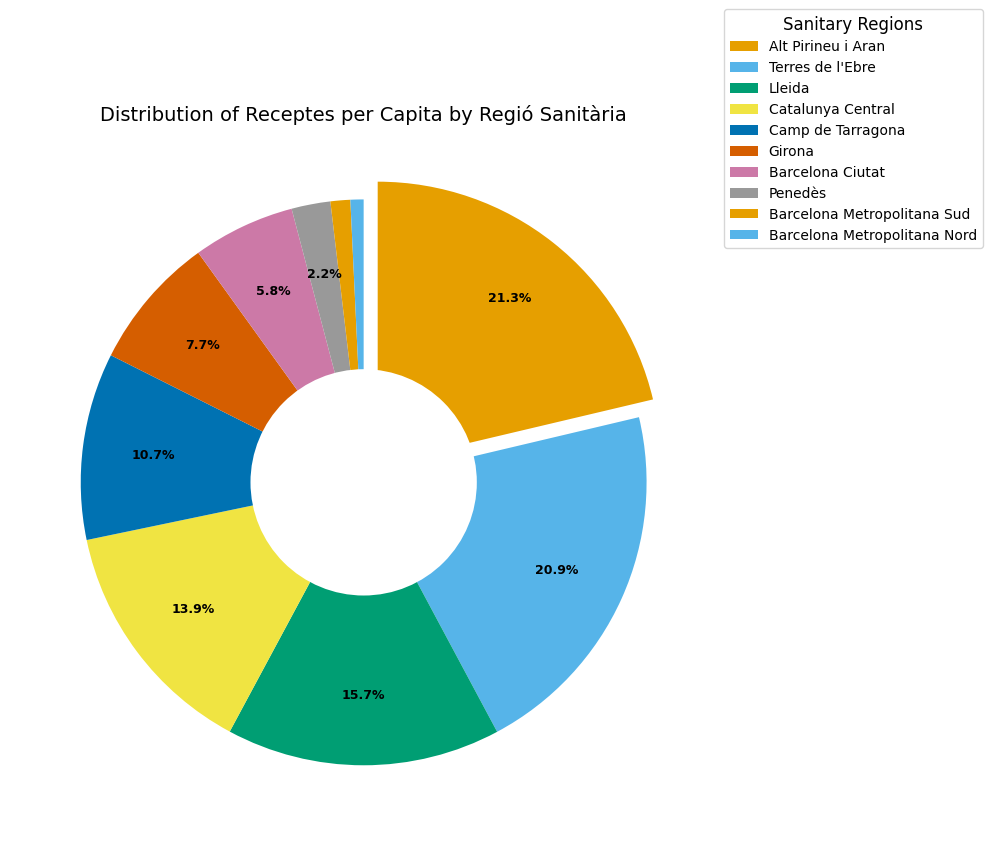

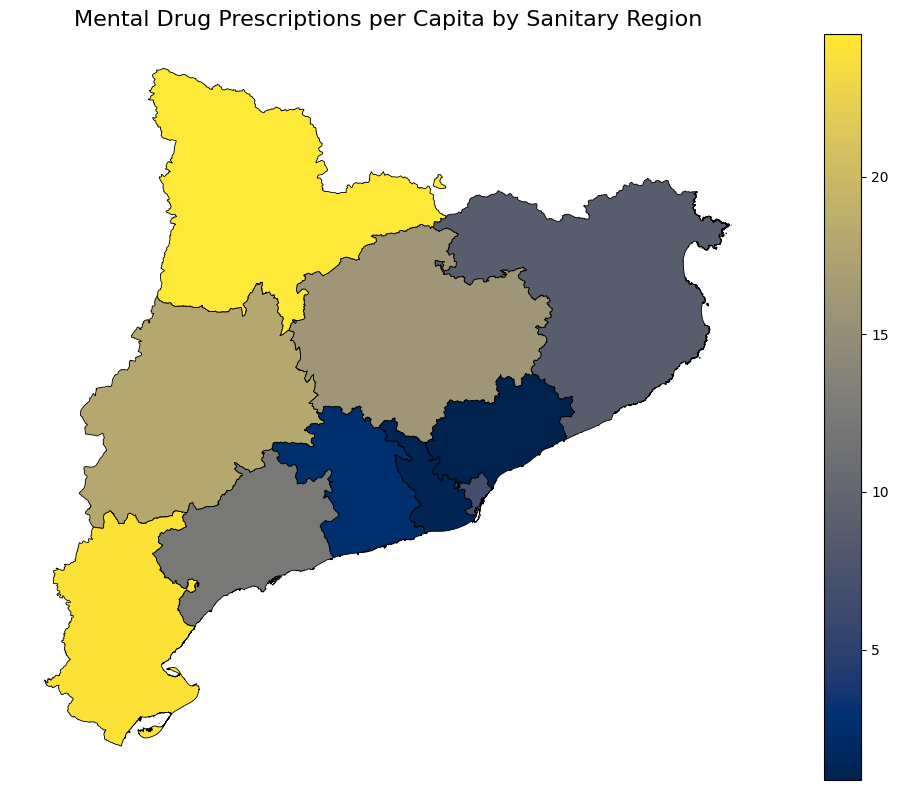

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 1. GeoJSON

gdf = gpd.read_file("Ad_Dataset.geojson")
gdf = gdf.rename(columns={"nom": "Regió Sanitària"})

# 2. DRUGS CSV (with auto column detection)

df = pd.read_csv("Dataset.csv", encoding="latin-1")
for i, col in enumerate(df.columns):
    print(i, col)

# 3. POPULATION CSV 

df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')
        
# Display column names to see what we're working with
print("Columns in population CSV:")
print(df_population.columns.tolist())
        
# Rename columns if they have encoding issues
if 'RegiÃ³ SanitÃ ria' in df_population.columns:
            df_population = df_population.rename(columns={'RegiÃ³ SanitÃ ria': 'Regió Sanitària'})
if 'poblaciÃ³ oficial' in df_population.columns:
            df_population = df_population.rename(columns={'poblaciÃ³ oficial': 'població oficial'})
        
# Check available years
available_years = df_population['any'].unique()
print(f"Available years: {sorted(available_years)}")
        
# Filter for year 2025 (or use latest available)
if 2025 in available_years:
    df_2025 = df_population[df_population['any'] == 2025]
    print(f"Using data from year: 2025")
else:
    latest_year = max(available_years)
    df_2025 = df_population[df_population['any'] == latest_year]
    print(f"2025 not found. Using latest available year: {latest_year}")
        
print(f"Filtered data shape: {df_2025.shape}")
        
# Sum population by region
population_by_region = df_2025.groupby('Regió Sanitària')['població oficial'].sum().reset_index()
        
print(f"\nPopulation data regions: {population_by_region['Regió Sanitària'].unique()}")
        
    # Mapping dictionary to standardize region names
region_mapping = {
    'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
    'ALTRES': 'No consta',
    'BARCELONA': 'Barcelona Ciutat',
    'BARCELONA CIUTAT': 'Barcelona Ciutat',
    'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
    'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
    'CAMP DE TARRAGONA': 'Camp de Tarragona',
    'CATALUNYA CENTRAL': 'Catalunya Central',
    'GIRONA': 'Girona',
    'LLEIDA': 'Lleida',
    'PENEDÃ\x88S': 'Penedès',
    'SENSE ESPECIFICAR': 'No consta',
    "TERRES DE L'EBRE": "Terres de l'Ebre"
}
        
# Apply mapping to population data
population_by_region['Regió Sanitària'] = population_by_region['Regió Sanitària'].map(region_mapping)
population_by_region = population_by_region.dropna(subset=['Regió Sanitària'])
population_by_region = (
    population_by_region
    .groupby('Regió Sanitària', as_index=False)['població oficial']
    .sum()
)

print(f"\nAfter mapping - GeoJSON regions: {sorted(gdf['Regió Sanitària'].unique())}")
print(f"After mapping - Population regions: {sorted(population_by_region['Regió Sanitària'].unique())}")

# Merge GeoJSON with population data
merged_gdf = gdf.merge(population_by_region, on='Regió Sanitària', how='left')
        
print(f"\nMerged GeoDataFrame shape: {merged_gdf.shape}")
print("Merged data sample:")
print(merged_gdf[['Regió Sanitària', 'població oficial']].head())
        
# Check for regions with missing data
missing_data = merged_gdf[merged_gdf['població oficial'].isna()]
if len(missing_data) > 0:
    print(f"\nRegions with missing population data: {len(missing_data)}")
    print(missing_data['Regió Sanitària'].tolist())

# Rename the corrupted column names
column_mapping = {
    'regiÃ³ sanitÃ ria': 'regió sanitària',
}
df = df.rename(columns=column_mapping)

# Select the columns we need
columns_to_merge = df[['regió sanitària', 'grup ATC nivell 3', 'nombre de receptes']]

# Filter for mental groups
mental_groups = [
    "ANTIDEPRESIVOS",
    "ANSIOLITICOS",
    "ANTIPSICOTICOS", 
    "HIPNOTICOS Y SEDANTES",
    "FARMACOS USADOS EN DESORDENES ADICTIVOS",
    "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS",
    "OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO"
]

mental_drugs_df = columns_to_merge[columns_to_merge['grup ATC nivell 3'].isin(mental_groups)]

# SUM ALL mental drug prescriptions grouped ONLY by sanitary region
summed_by_region = mental_drugs_df.groupby('regió sanitària')['nombre de receptes'].sum().reset_index()


# Create a mapping dictionary to standardize region names
region_mapping = {
    'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
    'ALTRES': 'No consta',  # Map 'ALTRES' to 'No consta'
    'BARCELONA': 'Barcelona Ciutat',  # Assuming BARCELONA refers to Barcelona Ciutat
    'BARCELONA CIUTAT': 'Barcelona Ciutat',
    'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
    'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
    'CAMP DE TARRAGONA': 'Camp de Tarragona',
    'CATALUNYA CENTRAL': 'Catalunya Central',
    'GIRONA': 'Girona',
    'LLEIDA': 'Lleida',
    'PENEDÃ\x88S': 'Penedès',  # Fix encoding issue
    'SENSE ESPECIFICAR': 'No consta',  # Map 'SENSE ESPECIFICAR' to 'No consta'
    "TERRES DE L'EBRE": "Terres de l'Ebre"
}

# Apply the mapping to the CSV data
summed_by_region['regió sanitària'] = summed_by_region['regió sanitària'].map(region_mapping)

# Remove any rows that couldn't be mapped (if any)
summed_by_region = summed_by_region.dropna(subset=['regió sanitària'])

summed_by_region = (
    summed_by_region
    .groupby('regió sanitària', as_index=False)['nombre de receptes']
    .sum()
)

print("\nAfter mapping:")
print(f"GeoDataFrame regions: {sorted(gdf['Regió Sanitària'].unique())}")
print(f"CSV regions: {sorted(summed_by_region['regió sanitària'].unique())}")

summed_by_region = summed_by_region.rename(columns={"regió sanitària": "Regió Sanitària"})

merged = merged_gdf.merge(summed_by_region, on="Regió Sanitària", how="left")

merged["receptes_per_capita"] = merged["nombre de receptes"] / merged["població oficial"]

# Pie-chart graph of the prescriptions per capita by region
label_map = {
    "Barcelona Ciutat": "BCN City",
    "Barcelona Metropolitana Nord": "BCN Metro N",
    "Barcelona Metropolitana Sud": "BCN Metro S",
    "Catalunya Central": "Catalunya Central",
    "Camp de Tarragona": "Tarragona",
    "Girona": "Girona",
    "Penedès": "Penedès",
    "Terres de l'Ebre": "Terres de l'Ebre",
    "Alt Pirineu i Aran": "Alt Pirineu i Aran",
    "Lleida": "Lleida"
}
pie_df = merged[['Regió Sanitària', 'receptes_per_capita']].copy()
pie_df = pie_df.dropna(subset=['receptes_per_capita'])
pie_df = pie_df.sort_values('receptes_per_capita', ascending=False)
pie_values = pie_df['receptes_per_capita'] / pie_df['receptes_per_capita'].sum()
pie_df['Regió Sanitària Renamed'] = pie_df['Regió Sanitària'].map(label_map).fillna(pie_df['Regió Sanitària'])

# explode only the largest slice (first after sorting)
explode = [0.08] + [0] * (len(pie_values) - 1)
# ---- 2. Colorblind-safe palette (Okabe–Ito) ----
okabe_ito = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999"
]
# If you have more regions than 8, repeat palette
colors = (okabe_ito * ((len(pie_values) // len(okabe_ito)) + 1))[:len(pie_values)]
# ---- 3. Plot ----
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    pie_values,
    autopct=lambda p: f'{p:.1f}%' if p >= 2.2 else '',
    explode=explode,
    colors=colors,
    pctdistance=0.75,       # move percent labels inward
    labeldistance=1.05,     # move region labels outward -> reduces overlap
    startangle=90,
    counterclock=False
)
# ---- 4. Improving label readability ----
plt.setp(texts, fontsize=10)
plt.setp(autotexts, fontsize=9, weight='bold')
# Optional donut-style center circle (helps readability)
centre = plt.Circle((0, 0), 0.40, fc='white')
ax.add_artist(centre)
ax.set_title('Distribution of Receptes per Capita by Regió Sanitària', fontsize=14)
ax.legend(
    wedges,
    pie_df['Regió Sanitària'],
    title="Sanitary Regions",
    loc="center left",
    bbox_to_anchor=(1, 1),
    fontsize=10,
    title_fontsize=12
)
plt.tight_layout()
plt.show()

# 6. Plot heatmap

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merged.plot(
    column="receptes_per_capita",
    ax=ax,
    cmap="cividis",
    legend=True,
    edgecolor="black",
    linewidth=0.6,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

plt.title("Mental Drug Prescriptions per Capita by Sanitary Region", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


Bivariate Choropleth Map (Drugs per capita vs socioeconomical value (averaged over the comarques))

Because of the lack of data available, we will set all comarques in an specific sanitary region. We will compute the average across all comarques without pondering with their population density



Take the drug prescription and socieconomic value per year as different points 
Exponential relation?
Eix x -> nivell socioeconomic


C:\Users\ismar\AppData\Local\Temp\ipykernel_3612\3942725407.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)


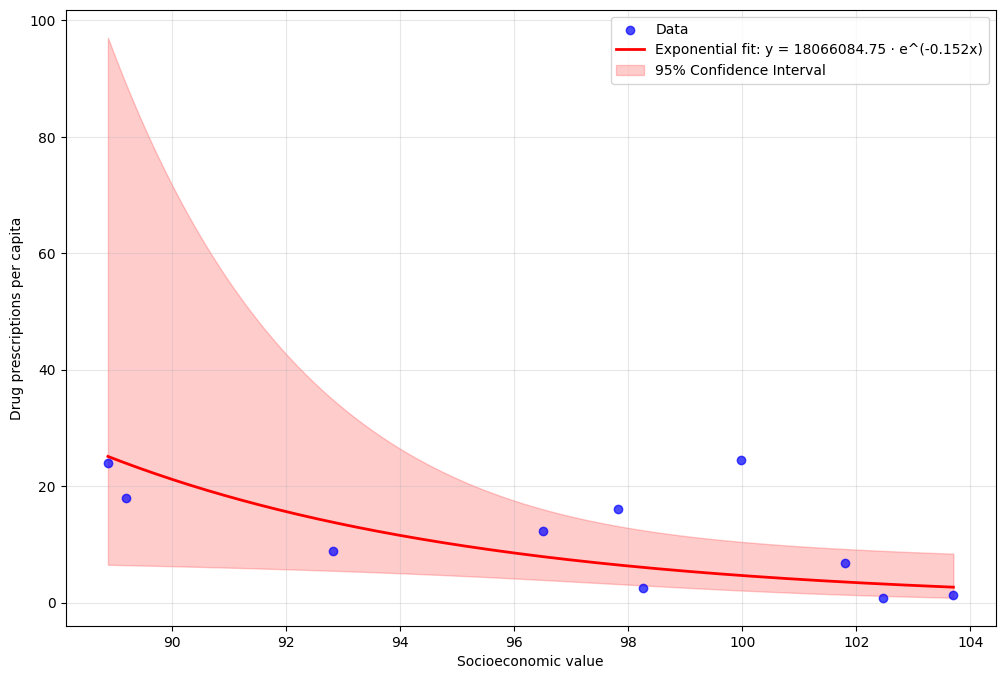

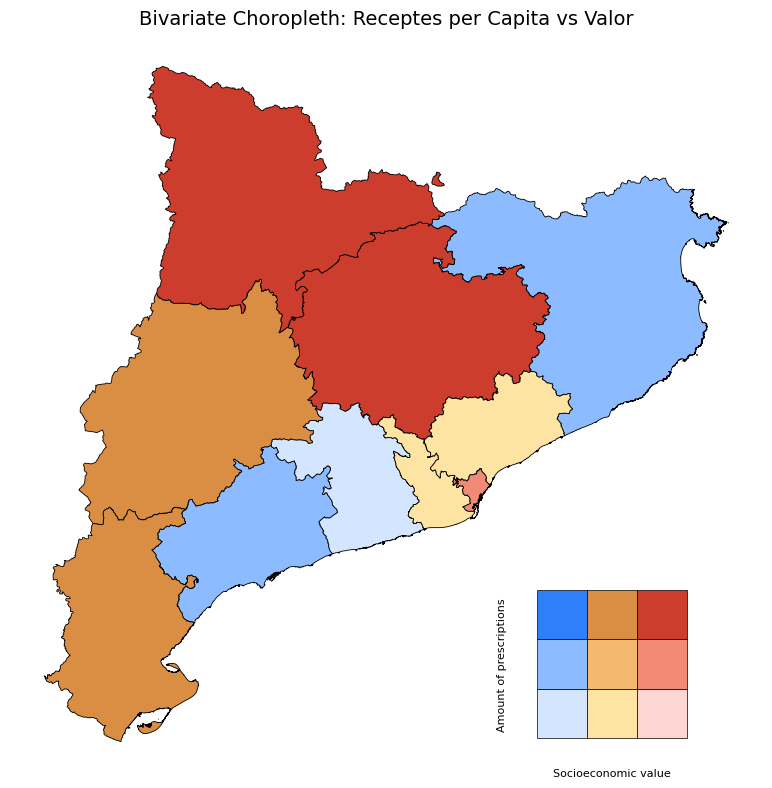

In [2]:
com_to_reg = {
    "Alt Camp": "Camp de Tarragona",
    "Alt Empordà": "Girona",
    "Alt Penedès": "Penedès",
    "Alt Urgell": "Alt Pirineu i Aran",
    "Alta Ribagorça": "Alt Pirineu i Aran",
    "Anoia": "Penedès",
    "Aran": "Alt Pirineu i Aran",
    "Bages": "Catalunya Central",
    "Baix Camp": "Camp de Tarragona",
    "Baix Ebre": "Terres de l'Ebre",
    "Baix Empordà": "Girona",
    "Baix Llobregat": "Barcelona Metropolitana Sud",
    "Baix Penedès": "Penedès",
    "Barcelonès": "Barcelona Ciutat",
    "Berguedà": "Catalunya Central",
    "Cerdanya": "Alt Pirineu i Aran",
    "Conca de Barberà": "Camp de Tarragona",
    "Garraf": "Penedès",
    "Garrigues": "Lleida",
    "Garrotxa": "Girona",
    "Gironès": "Girona",
    "Maresme": "Barcelona Metropolitana Nord",
    "Moianès": "Catalunya Central",
    "Montsià": "Terres de l'Ebre",
    "Noguera": "Lleida",
    "Osona": "Catalunya Central",
    "Pallars Jussà": "Alt Pirineu i Aran",
    "Pallars Sobirà": "Alt Pirineu i Aran",
    "Pla d'Urgell": "Lleida",
    "Pla de l'Estany": "Girona",
    "Priorat": "Camp de Tarragona",
    "Ribera d'Ebre": "Terres de l'Ebre",
    "Ripollès": "Girona",
    "Segarra": "Lleida",
    "Segrià": "Lleida",
    "Selva": "Girona",
    "Solsonès": "Catalunya Central",
    "Tarragonès": "Camp de Tarragona",
    "Terra Alta": "Terres de l'Ebre",
    "Urgell": "Lleida",
    "Vallès Occidental": "Barcelona Metropolitana Nord",
    "Vallès Oriental": "Barcelona Metropolitana Nord"
}

socioec_df = pd.read_excel('Ad_Dataset3.xlsx')

socioec_rec = socioec_df[socioec_df['Any'] == 2022] # Most recent data
socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
socioec_rec = socioec_rec.groupby('Regió Sanitària')['Valor'].mean().reset_index()

merged = merged.merge(socioec_rec, on="Regió Sanitària", how="left")

# We delete missing data
merged_clean = merged.dropna(subset=['receptes_per_capita', 'Valor']).copy()

x = merged_clean['Valor'].values
y = merged_clean['receptes_per_capita'].values
# Remove non-positive y values (cannot take log)
valid = y > 0
x = x[valid]
y = y[valid]
# ---- EXPONENTIAL REGRESSION ----
# Fit: ln(y) = A + Bx
log_y = np.log(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_y)
# Convert back to exponential params
A = np.exp(intercept)   # a = exp(intercept)
B = slope               # b = slope
# Smooth curve
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = A * np.exp(B * x_smooth)
# ---- CONFIDENCE INTERVAL (95%) ----
n = len(x)
x_mean = np.mean(x)
# Predictions in log space
log_y_pred = intercept + slope*x
# Standard error of fit (in log space)
s_err = np.sqrt(np.sum((log_y - log_y_pred)**2) / (n - 2))
t_val = stats.t.ppf(0.975, n - 2)
# CI for exp model: convert back from log-space
conf_log = t_val * s_err * np.sqrt(1/n + (x_smooth - x_mean)**2 / np.sum((x - x_mean)**2))
# Upper/lower bands in real scale
y_upper = np.exp(np.log(y_smooth) + conf_log)
y_lower = np.exp(np.log(y_smooth) - conf_log)
# ---- PLOT ----
plt.figure(figsize=(12, 8))
plt.scatter(x, y, alpha=0.7, color='blue', label="Data", zorder=5)
plt.plot(x_smooth, y_smooth, color='red', linewidth=2,
         label=f"Exponential fit: y = {A:.2f} · e^({B:.3f}x)")
plt.fill_between(x_smooth, y_lower, y_upper, color='red', alpha=0.2,
                 label='95% Confidence Interval')
plt.xlabel('Socioeconomic value')
plt.ylabel('Drug prescriptions per capita')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


def create_bivariate_legend(ax, colors, x_pos=0.70, y_pos=0.05, size=0.20):
    """Create a bivariate legend using axis fraction coordinates."""
    from matplotlib.patches import Rectangle
    
    for i in range(3):
        for j in range(3):
            color_idx = i * 3 + j
            rect = Rectangle(
                (x_pos + j * size/3, y_pos + i * size/3),
                size/3,
                size/3,
                transform=ax.transAxes,   # <-- IMPORTANT
                facecolor=colors[color_idx],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)

    # Labels
    ax.text(x_pos + size/2, y_pos - 0.04, 'Socioeconomic value',
            ha='center', va='top', fontsize=8, transform=ax.transAxes)

    #ax.text(x_pos + size/2, y_pos + size + 0.04, 'High Valor',
           # ha='center', va='bottom', fontsize=8, transform=ax.transAxes)

    ax.text(x_pos - 0.04, y_pos + size/2, 'Amount of prescriptions',
            ha='right', va='center', fontsize=8, rotation=90, transform=ax.transAxes)

    #ax.text(x_pos + size + 0.04, y_pos + size/2, 'High Receptes',
           # ha='left', va='center', fontsize=8, rotation=90, transform=ax.transAxes)


# Create your base map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merged_clean['rec_class'] = pd.qcut(merged_clean['receptes_per_capita'], 3, labels=[1,2,3])
merged_clean['val_class'] = pd.qcut(merged_clean['Valor'], 3, labels=[1,2,3])

merged_clean['bivariate_class'] = (
    (merged_clean['rec_class'].astype(int) - 1) * 3
    + merged_clean['val_class'].astype(int)
)

# Define colors 
bivariate_colors = [
    '#d3e5ff', '#fee4a2', '#fcd6d2',   # top row (dark)
    '#8cbcff', '#f4b96f', '#f28a78',   # middle row
    '#2e7ff9', '#d98e44', '#cc3d2d'    # bottom row (light)
]


# Plot
merged_clean.plot(
    column='bivariate_class',
    categorical=True,
    cmap=plt.cm.colors.ListedColormap(bivariate_colors),
    ax=ax,
    edgecolor="black",
    linewidth=0.6,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

leg = ax.get_legend()
if leg:
    leg.remove()
    
ax.set_title('Bivariate Choropleth: Receptes per Capita vs Valor', fontsize=14)
ax.set_axis_off()

# Add the legend (using the function from Method 1)
create_bivariate_legend(ax, bivariate_colors)
plt.tight_layout()
plt.show()


C:\Users\ismar\AppData\Local\Temp\ipykernel_3612\581431781.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_clean["centroid"] = merged_clean.geometry.centroid
C:\Users\ismar\AppData\Local\Temp\ipykernel_3612\581431781.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_clean["x"] = merged_clean.centroid.x
C:\Users\ismar\AppData\Local\Temp\ipykernel_3612\581431781.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_clean["y"] = merged_clean.centroid.y


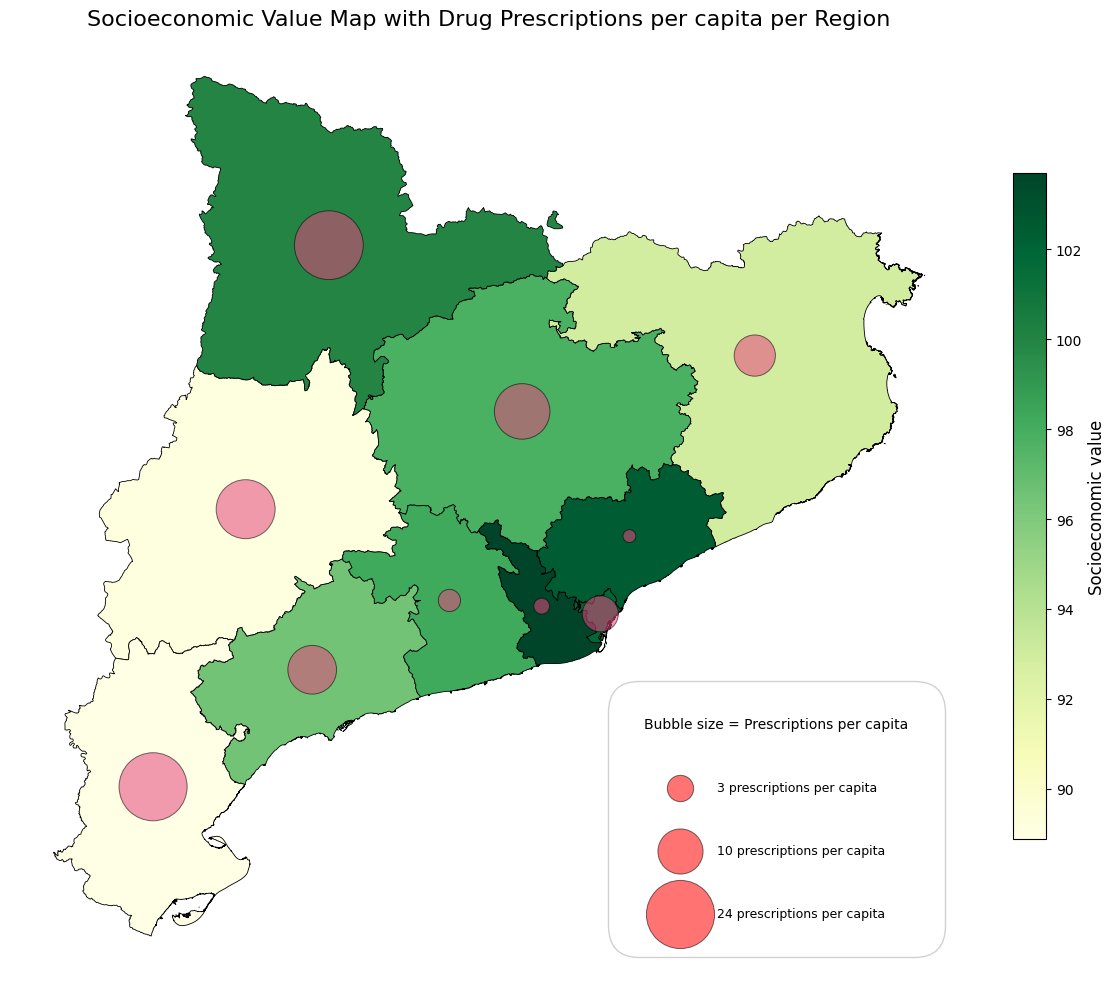

In [25]:
# -------------------------------
#  MAP: Socioeconomic colour + bubble size = prescriptions
# -------------------------------

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 1. BASE MAP COLOURED BY SOCIOECONOMIC VALUE
merged_clean.plot(
    column="Valor",
    cmap="YlGn",
    legend=False,
    edgecolor="black",
    linewidth=0.6,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
sm = plt.cm.ScalarMappable(cmap="YlGn", 
                           norm=plt.Normalize(vmin=merged_clean["Valor"].min(),
                                              vmax=merged_clean["Valor"].max()))
sm._A = []  # empty array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Socioeconomic value", fontsize=12)
# 2. ADD BUBBLES SIZED BY TOTAL DRUG PRESCRIPTIONS (NOW BIGGER)
# Centroids
merged_clean["centroid"] = merged_clean.geometry.centroid
merged_clean["x"] = merged_clean.centroid.x
merged_clean["y"] = merged_clean.centroid.y

# Increase bubble size scale
bubble_scale = 0.01   # smaller divisor → larger bubbles

# Plot bubbles
ax.scatter(
    merged_clean["x"],
    merged_clean["y"],
    s=merged_clean["receptes_per_capita"] / bubble_scale,
    color="#E64580",
    alpha=0.55,
    edgecolor="black",
    linewidth=0.7,
    zorder=4
)

# 3. --- BUBBLE SIZE LEGEND ---
# Choose 3 typical values
legend_sizes = [
    merged_clean["receptes_per_capita"].quantile(0.25),
    merged_clean["receptes_per_capita"].quantile(0.50),
    merged_clean["receptes_per_capita"].quantile(0.90)
]

legend_labels = [
    f"{int(legend_sizes[0]):,} prescriptions per capita",
    f"{int(legend_sizes[1]):,} prescriptions per capita",
    f"{int(legend_sizes[2]):,} prescriptions per capita"
]

# Fake scatter for legend
for size, label in zip(legend_sizes, legend_labels):
    ax.scatter([], [], 
               s=size / bubble_scale,
               color="red", alpha=0.55, edgecolor="black", linewidth=0.7,
               label=label)

legend = ax.legend(
    title="Bubble size = Prescriptions per capita",
    loc="lower center",
    bbox_to_anchor=(0.8, 0.05),
    ncol=1,
    frameon=True,
    fontsize=9,
    title_fontsize=10,
    handletextpad=2.0,
    labelspacing=4  # increases vertical spacing
)

legend.get_frame().set_alpha(0.9)
legend.get_frame().set_boxstyle("round,pad=2.5")
# 4. TITLE & CLEANUP
ax.set_title(
    "Socioeconomic Value Map with Drug Prescriptions per capita per Region",
    fontsize=16
)
ax.set_axis_off()

plt.tight_layout()
plt.show()


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:9: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' 'SENSE ESPECIFICAR' "TERRES DE L'EBRE"]
After mapping - Population regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:56: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut

After mapping:
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:9: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' 'SENSE ESPECIFICAR' "TERRES DE L'EBRE"]
After mapping - Population regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:56: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut

After mapping:
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:9: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' 'SENSE ESPECIFICAR' "TERRES DE L'EBRE"]
After mapping - Population regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:56: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut

After mapping:
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:9: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' "TERRES DE L'EBRE"]
After mapping - Population regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:56: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut

After mapping:
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:9: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' "TERRES DE L'EBRE"]
After mapping - Population regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:56: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut

After mapping:
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:9: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' "TERRES DE L'EBRE"]
After mapping - Population regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:56: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut

After mapping:
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


C:\Users\ismar\AppData\Local\Temp\ipykernel_4092\1102339556.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)


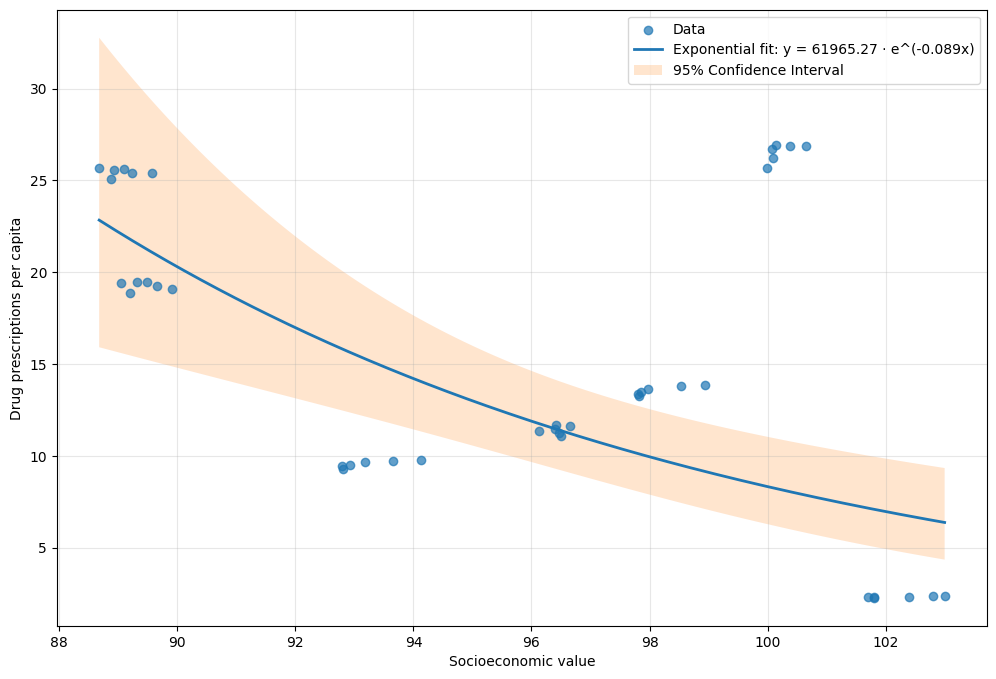


 EXPONENTIAL REGRESSION DIAGNOSTICS
Model: y = 61965.2652 * e^(-0.0892 * x)
Slope (B):             -0.089156
Intercept ln(A):       11.034329
A (exp intercept):     61965.265209
R² (log-space):        0.3034
Adjusted R²:           0.2677
p-value (slope):       1.5677e-04
Std error (slope):     0.021359
RMSE (log y):          0.645806
RMSE (original y):     7.770294
n observations:        42



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def year_filter(year):
    # 1. POPULATION CSV 

    df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')
            
    # Display column names to see what we're working with
    print("Columns in population CSV:")
    print(df_population.columns.tolist())
            
    # Rename columns if they have encoding issues
    if 'RegiÃ³ SanitÃ ria' in df_population.columns:
                df_population = df_population.rename(columns={'RegiÃ³ SanitÃ ria': 'Regió Sanitària'})
    if 'poblaciÃ³ oficial' in df_population.columns:
                df_population = df_population.rename(columns={'poblaciÃ³ oficial': 'població oficial'})     
    df_population = df_population[df_population['any'] == year]
    # Sum population by region
    population_by_region = df_population.groupby('Regió Sanitària')['població oficial'].sum().reset_index()
            
    print(f"\nPopulation data regions: {population_by_region['Regió Sanitària'].unique()}")
            
        # Mapping dictionary to standardize region names
    region_mapping = {
        'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
        'ALTRES': 'No consta',
        'BARCELONA': 'Barcelona Ciutat',
        'BARCELONA CIUTAT': 'Barcelona Ciutat',
        'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
        'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
        'CAMP DE TARRAGONA': 'Camp de Tarragona',
        'CATALUNYA CENTRAL': 'Catalunya Central',
        'GIRONA': 'Girona',
        'LLEIDA': 'Lleida',
        'PENEDÃ\x88S': 'Penedès',
        'SENSE ESPECIFICAR': 'No consta',
        "TERRES DE L'EBRE": "Terres de l'Ebre"
    }
            
    # Apply mapping to population data
    population_by_region['Regió Sanitària'] = population_by_region['Regió Sanitària'].map(region_mapping)
    population_by_region = population_by_region.dropna(subset=['Regió Sanitària'])
    population_by_region = (
    population_by_region
    .groupby('Regió Sanitària', as_index=False)['població oficial']
    .sum()
    )
        
    print(f"After mapping - Population regions: {sorted(population_by_region['Regió Sanitària'].unique())}")

    # 2. DRUGS CSV (with auto column detection)

    df = pd.read_csv("Dataset.csv", encoding="latin-1")
    for i, col in enumerate(df.columns):
        print(i, col)
        
    # Rename the corrupted column names
    column_mapping = {
        'regiÃ³ sanitÃ ria': 'regió sanitària',
    }
    df = df.rename(columns=column_mapping)

    # Select the columns we need
    columns_to_merge = df[['regió sanitària', 'grup ATC nivell 3', 'nombre de receptes']]

    # Filter for mental groups
    mental_groups = [
        "ANTIDEPRESIVOS",
        "ANSIOLITICOS",
        "ANTIPSICOTICOS", 
        "HIPNOTICOS Y SEDANTES",
        "FARMACOS USADOS EN DESORDENES ADICTIVOS",
        "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION",
        "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS",
        "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS",
        "OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO"
    ]

    mental_drugs_df = columns_to_merge[columns_to_merge['grup ATC nivell 3'].isin(mental_groups)]

    # SUM ALL mental drug prescriptions grouped ONLY by sanitary region
    summed_by_region = mental_drugs_df.groupby('regió sanitària')['nombre de receptes'].sum().reset_index()


    # Create a mapping dictionary to standardize region names
    region_mapping = {
        'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
        'ALTRES': 'No consta',  # Map 'ALTRES' to 'No consta'
        'BARCELONA': 'Barcelona Ciutat',  # Assuming BARCELONA refers to Barcelona Ciutat
        'BARCELONA CIUTAT': 'Barcelona Ciutat',
        'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
        'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
        'CAMP DE TARRAGONA': 'Camp de Tarragona',
        'CATALUNYA CENTRAL': 'Catalunya Central',
        'GIRONA': 'Girona',
        'LLEIDA': 'Lleida',
        'PENEDÃ\x88S': 'Penedès',  # Fix encoding issue
        'SENSE ESPECIFICAR': 'No consta',  # Map 'SENSE ESPECIFICAR' to 'No consta'
        "TERRES DE L'EBRE": "Terres de l'Ebre"
    }

    # Apply the mapping to the CSV data
    summed_by_region['regió sanitària'] = summed_by_region['regió sanitària'].map(region_mapping)

    # Remove any rows that couldn't be mapped (if any)
    summed_by_region = summed_by_region.dropna(subset=['regió sanitària'])
    summed_by_region = (
    summed_by_region
    .groupby('regió sanitària', as_index=False)['nombre de receptes']
    .sum()
    )

    print("\nAfter mapping:")
    print(f"CSV regions: {sorted(summed_by_region['regió sanitària'].unique())}")

    summed_by_region = summed_by_region.rename(columns={"regió sanitària": "Regió Sanitària"})

    merged = population_by_region.merge(summed_by_region, on="Regió Sanitària", how="left")

    merged["receptes_per_capita"] = merged["nombre de receptes"] / merged["població oficial"]
    
    com_to_reg = {
        "Alt Camp": "Camp de Tarragona",
        "Alt Empordà": "Girona",
        "Alt Penedès": "Penedès",
        "Alt Urgell": "Alt Pirineu i Aran",
        "Alta Ribagorça": "Alt Pirineu i Aran",
        "Anoia": "Penedès",
        "Aran": "Alt Pirineu i Aran",
        "Bages": "Catalunya Central",
        "Baix Camp": "Camp de Tarragona",
        "Baix Ebre": "Terres de l'Ebre",
        "Baix Empordà": "Girona",
        "Baix Llobregat": "Barcelona Metropolitana Sud",
        "Baix Penedès": "Penedès",
        "Barcelonès": "Barcelona Ciutat",
        "Berguedà": "Catalunya Central",
        "Cerdanya": "Alt Pirineu i Aran",
        "Conca de Barberà": "Camp de Tarragona",
        "Garraf": "Penedès",
        "Garrigues": "Lleida",
        "Garrotxa": "Girona",
        "Gironès": "Girona",
        "Maresme": "Barcelona Metropolitana Nord",
        "Moianès": "Catalunya Central",
        "Montsià": "Terres de l'Ebre",
        "Noguera": "Lleida",
        "Osona": "Catalunya Central",
        "Pallars Jussà": "Alt Pirineu i Aran",
        "Pallars Sobirà": "Alt Pirineu i Aran",
        "Pla d'Urgell": "Lleida",
        "Pla de l'Estany": "Girona",
        "Priorat": "Camp de Tarragona",
        "Ribera d'Ebre": "Terres de l'Ebre",
        "Ripollès": "Girona",
        "Segarra": "Lleida",
        "Segrià": "Lleida",
        "Selva": "Girona",
        "Solsonès": "Catalunya Central",
        "Tarragonès": "Camp de Tarragona",
        "Terra Alta": "Terres de l'Ebre",
        "Urgell": "Lleida",
        "Vallès Occidental": "Barcelona Metropolitana Nord",
        "Vallès Oriental": "Barcelona Metropolitana Nord"
    }

    socioec_df = pd.read_excel('Ad_Dataset3.xlsx')
    socioec_rec = socioec_df[socioec_df['Any'] == year] # Most recent data
    socioec_rec['Regió Sanitària'] = socioec_rec['Comarca'].map(com_to_reg)
    socioec_rec = socioec_rec.groupby('Regió Sanitària')['Valor'].mean().reset_index()

    merged = merged.merge(socioec_rec, on="Regió Sanitària", how="left")

    # We delete missing data
    merged_clean = merged.dropna(subset=['receptes_per_capita', 'Valor']).copy()
    return merged_clean



x = []
y = []
for year in [2017, 2018, 2019, 2020, 2021, 2022]:
        ydf = year_filter(year)
        x.append(ydf['Valor'].values)
        y.append(ydf['receptes_per_capita'].values)

# After the loop that builds x and y as lists of 1-D numpy arrays:

# 1) Concatenate lists of arrays into single 1-D arrays
if len(x) == 0 or len(y) == 0:
    raise ValueError("No data collected for any year.")

x = np.concatenate(x)
y = np.concatenate(y)

# 2) Ensure they have equal length
if x.shape[0] != y.shape[0]:
    raise ValueError(f"Length mismatch after concatenation: x={x.shape[0]}, y={y.shape[0]}")

# 3) Build a boolean mask to keep only valid observations:
#    - finite values
#    - y > 0 (since we take log)
mask = np.isfinite(x) & np.isfinite(y) & (y > 0)

# Optionally drop any extreme zeros or negatives in x if that makes sense:
# mask &= (x > some_min_value)   # uncomment and set some_min_value if needed

x = x[mask]
y = y[mask]

# Check we still have enough points
n = len(x)
if n < 3:
    raise ValueError(f"Not enough valid data points for regression (need at least 3, got {n}).")

# ---- EXPONENTIAL REGRESSION ----
# Fit: ln(y) = intercept + slope * x
log_y = np.log(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_y)

# Convert back to exponential params
A = np.exp(intercept)   # a = exp(intercept)
B = slope               # b = slope

# Smooth curve for plotting
x_smooth = np.linspace(np.min(x), np.max(x), 300)
y_smooth = A * np.exp(B * x_smooth)

# ---- CONFIDENCE INTERVAL (95%) ----
x_mean = np.mean(x)
log_y_pred = intercept + slope * x
s_err = np.sqrt(np.sum((log_y - log_y_pred)**2) / (n - 2))
t_val = stats.t.ppf(0.975, n - 2)
# standard error of prediction at x_smooth (in log-space)
conf_log = t_val * s_err * np.sqrt(1 / n + (x_smooth - x_mean)**2 / np.sum((x - x_mean)**2))
y_upper = np.exp(np.log(y_smooth) + conf_log)
y_lower = np.exp(np.log(y_smooth) - conf_log)

# ---- PLOT ----
plt.figure(figsize=(12, 8))
plt.scatter(x, y, alpha=0.7, label="Data", zorder=5)
plt.plot(x_smooth, y_smooth, linewidth=2, label=f"Exponential fit: y = {A:.2f} · e^({B:.3f}x)")
plt.fill_between(x_smooth, y_lower, y_upper, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Socioeconomic value')
plt.ylabel('Drug prescriptions per capita')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ---- DIAGNOSTICS ----
def print_fit_diagnostics(x, y, log_y, log_y_pred, r_value, p_value, s_err, A, B):
    import numpy as np

    n = len(x)
    
    # R^2 (in log-space)
    r2 = r_value**2
    
    # Adjusted R^2
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - 2 - 1)

    # RMSE in log-space
    rmse_log = np.sqrt(np.mean((log_y - log_y_pred)**2))

    # RMSE in original space
    y_pred = A * np.exp(B * x)
    rmse_y = np.sqrt(np.mean((y - y_pred)**2))

    # Print diagnostics
    print("\n==============================")
    print(" EXPONENTIAL REGRESSION DIAGNOSTICS")
    print("==============================")
    print(f"Model: y = {A:.4f} * e^({B:.4f} * x)")
    print(f"Slope (B):             {B:.6f}")
    print(f"Intercept ln(A):       {np.log(A):.6f}")
    print(f"A (exp intercept):     {A:.6f}")
    print(f"R² (log-space):        {r2:.4f}")
    print(f"Adjusted R²:           {r2_adj:.4f}")
    print(f"p-value (slope):       {p_value:.4e}")
    print(f"Std error (slope):     {s_err:.6f}")
    print(f"RMSE (log y):          {rmse_log:.6f}")
    print(f"RMSE (original y):     {rmse_y:.6f}")
    print(f"n observations:        {n}")
    print("==============================\n")


# Call diagnostics
print_fit_diagnostics(
    x=x,
    y=y,
    log_y=log_y,
    log_y_pred=log_y_pred,
    r_value=r_value,
    p_value=p_value,
    s_err=std_err,
    A=A,
    B=B
)




Different mental health drugs compared

C:\Users\ismar\AppData\Local\Temp\ipykernel_7348\3531110912.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")


0 any
1 mes
2 codi de la regiÃ³ sanitÃ ria
3 regiÃ³ sanitÃ ria
4 grup d'edat
5 sexe
6 codi del grup ATC nivell 1
7 grup ATC nivell 1
8 codi del grup ATC nivell 2
9 grup ATC nivell 2
10 codi del grup ATC nivell 3
11 grup ATC nivell 3
12 codi del grup ATC nivell 4
13 grup ATC nivell 4
14 nombre de receptes
15 nombre d'envasos
16 import Ã­ntegre
17 import aportaciÃ³ CatSalut


C:\Users\ismar\AppData\Local\Temp\ipykernel_7348\3531110912.py:19: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')


Columns in population CSV:
['any', 'codi RegiÃ³ SanitÃ\xa0ria', 'RegiÃ³ SanitÃ\xa0ria', 'codi Ã\x80rea BÃ\xa0sica de Saut', 'Ã\x80rea BÃ\xa0sica de Salut', 'gÃ¨nere', 'edat', 'poblaciÃ³ oficial']
Available years: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Using data from year: 2025
Filtered data shape: (76469, 8)

Population data regions: ['ALT PIRINEU i ARAN' 'BARCELONA CIUTAT' 'BARCELONA METROPOLITANA NORD'
 'BARCELONA METROPOLITANA SUD' 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL'
 'GIRONA' 'LLEIDA' 'PENEDÃ\x88S' "TERRES DE L'EBRE"]

After mapping - GeoJSON regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]
After mapping - Population regions:

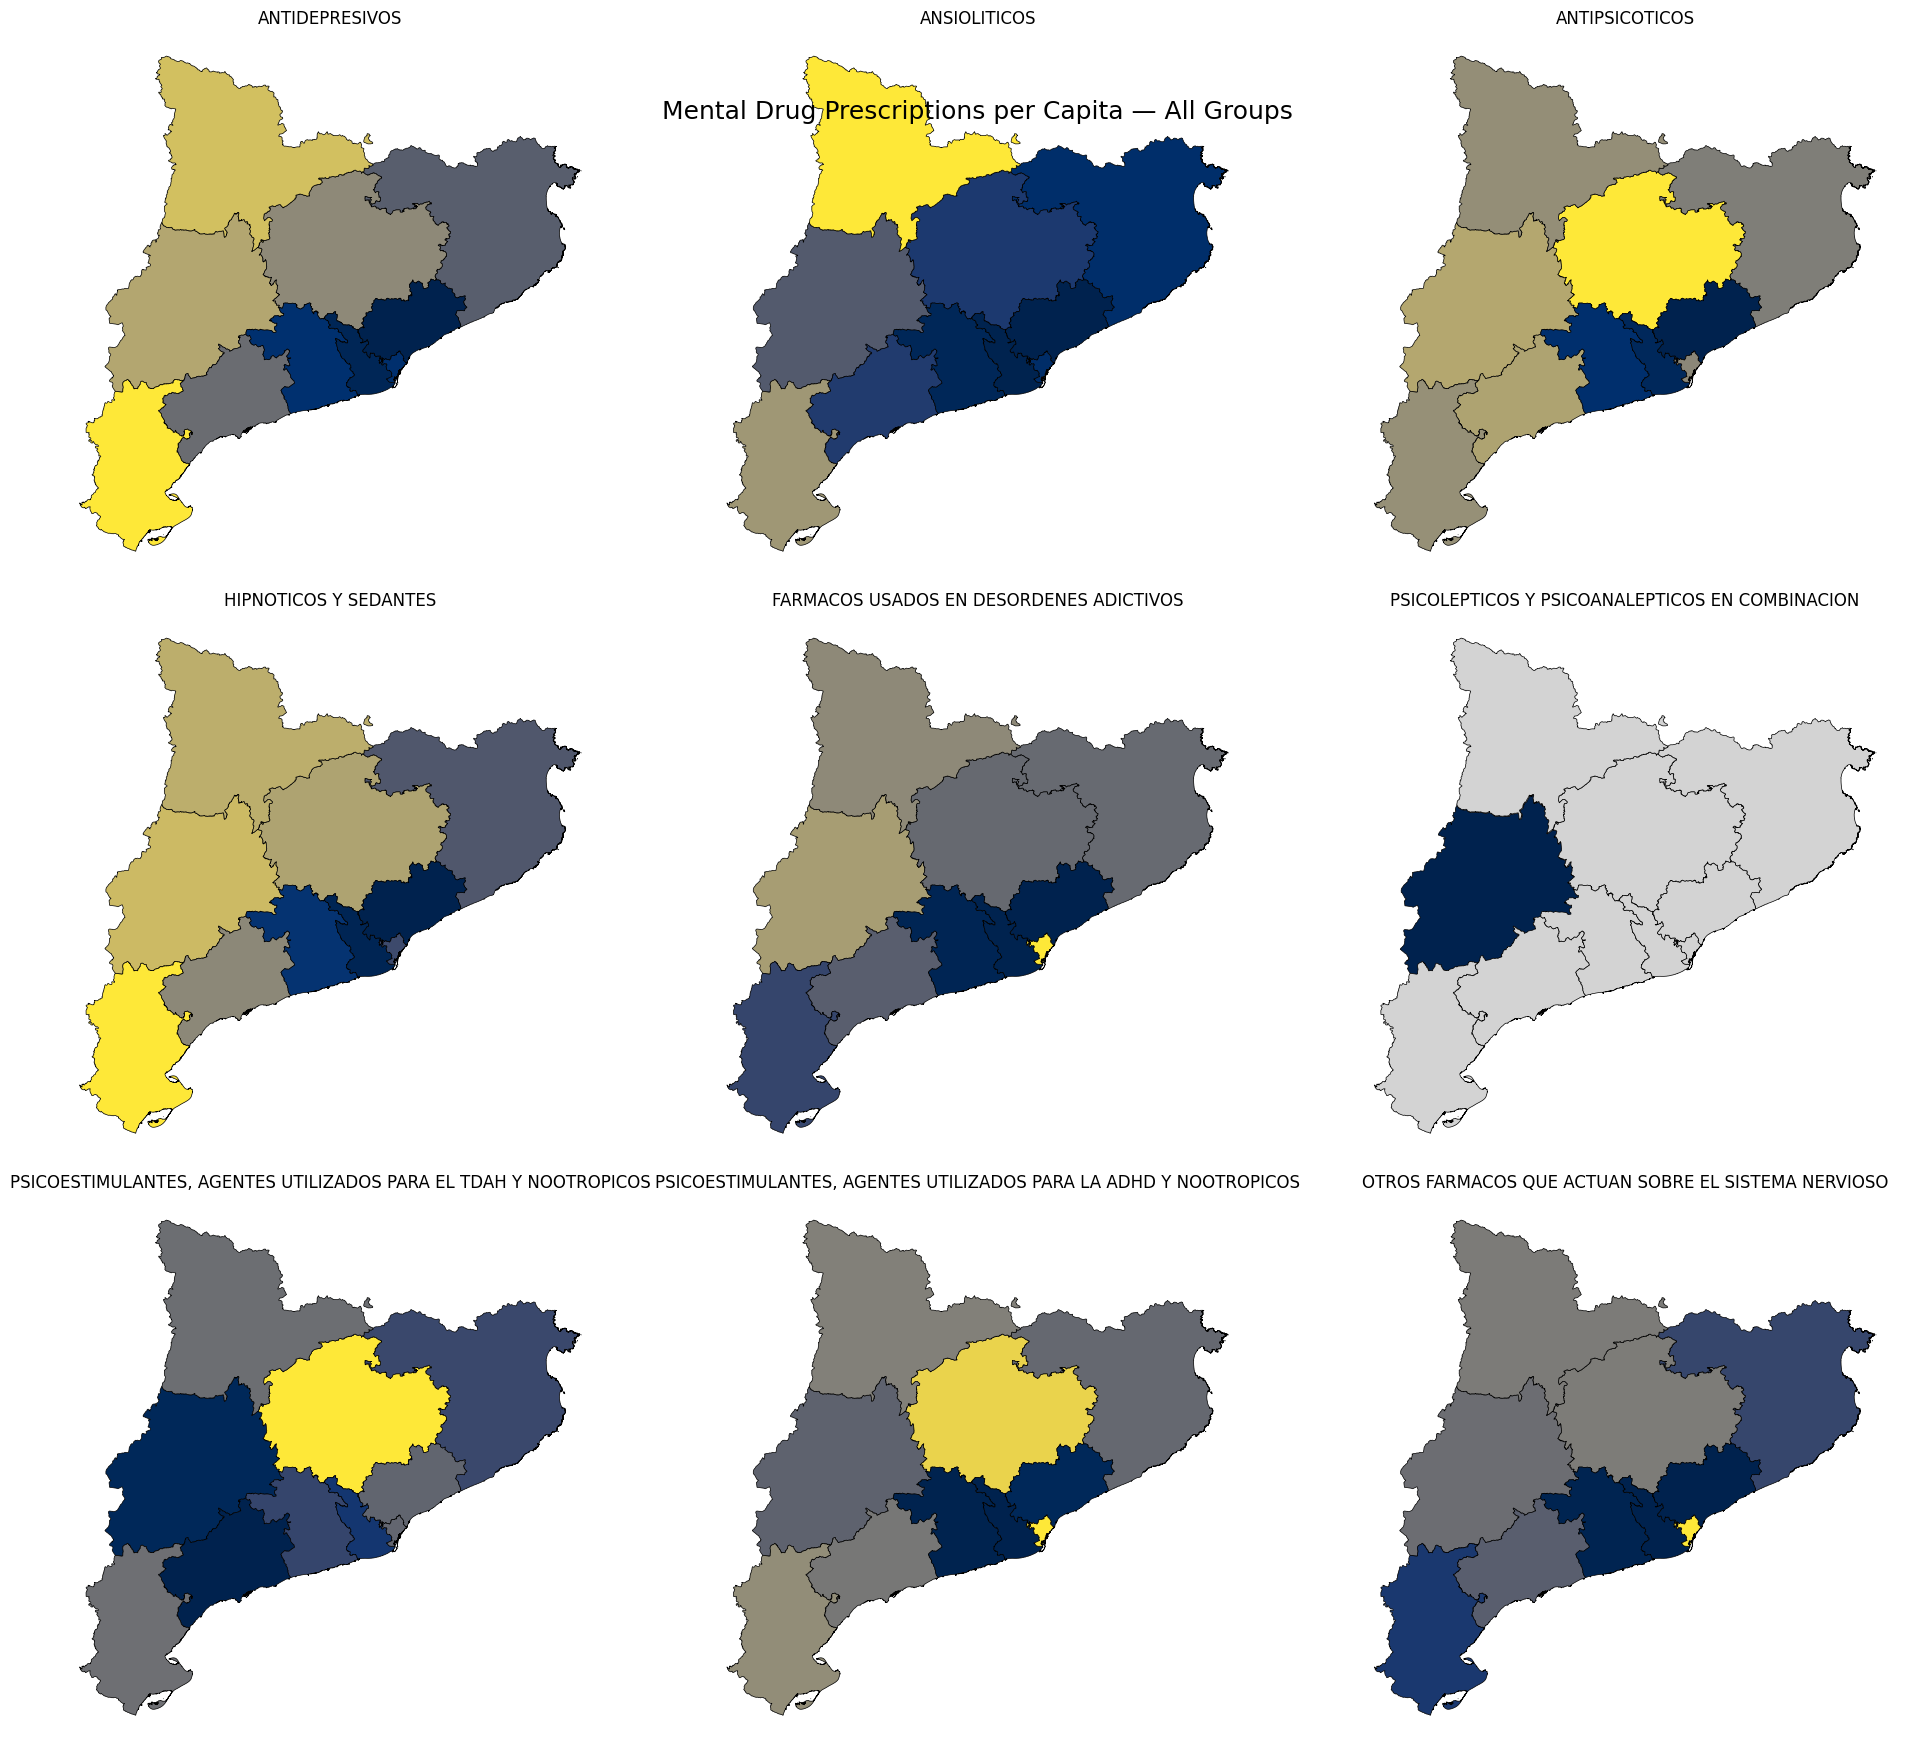

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import math

# 1. GeoJSON

gdf = gpd.read_file("Ad_Dataset.geojson")
gdf = gdf.rename(columns={"nom": "Regió Sanitària"})

# 2. DRUGS CSV (with auto column detection)

df = pd.read_csv("Dataset.csv", encoding="latin-1")
for i, col in enumerate(df.columns):
    print(i, col)

# 3. POPULATION CSV 

df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')
        
# Display column names to see what we're working with
print("Columns in population CSV:")
print(df_population.columns.tolist())
        
# Rename columns if they have encoding issues
if 'RegiÃ³ SanitÃ ria' in df_population.columns:
            df_population = df_population.rename(columns={'RegiÃ³ SanitÃ ria': 'Regió Sanitària'})
if 'poblaciÃ³ oficial' in df_population.columns:
            df_population = df_population.rename(columns={'poblaciÃ³ oficial': 'població oficial'})
        
# Check available years
available_years = df_population['any'].unique()
print(f"Available years: {sorted(available_years)}")
        
# Filter for year 2025 (or use latest available)
if 2025 in available_years:
    df_2025 = df_population[df_population['any'] == 2025]
    print(f"Using data from year: 2025")
else:
    latest_year = max(available_years)
    df_2025 = df_population[df_population['any'] == latest_year]
    print(f"2025 not found. Using latest available year: {latest_year}")
        
print(f"Filtered data shape: {df_2025.shape}")
        
# Sum population by region
population_by_region = df_2025.groupby('Regió Sanitària')['població oficial'].sum().reset_index()
        
print(f"\nPopulation data regions: {population_by_region['Regió Sanitària'].unique()}")
        
    # Mapping dictionary to standardize region names
region_mapping = {
    'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
    'ALTRES': 'No consta',
    'BARCELONA': 'Barcelona Ciutat',
    'BARCELONA CIUTAT': 'Barcelona Ciutat',
    'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
    'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
    'CAMP DE TARRAGONA': 'Camp de Tarragona',
    'CATALUNYA CENTRAL': 'Catalunya Central',
    'GIRONA': 'Girona',
    'LLEIDA': 'Lleida',
    'PENEDÃ\x88S': 'Penedès',
    'SENSE ESPECIFICAR': 'No consta',
    "TERRES DE L'EBRE": "Terres de l'Ebre"
}
        
# Apply mapping to population data
population_by_region['Regió Sanitària'] = population_by_region['Regió Sanitària'].map(region_mapping)
population_by_region = population_by_region.dropna(subset=['Regió Sanitària'])
population_by_region = (
    population_by_region
    .groupby('Regió Sanitària', as_index=False)['població oficial']
    .sum()
)

print(f"\nAfter mapping - GeoJSON regions: {sorted(gdf['Regió Sanitària'].unique())}")
print(f"After mapping - Population regions: {sorted(population_by_region['Regió Sanitària'].unique())}")

# Merge GeoJSON with population data
merged_gdf = gdf.merge(population_by_region, on='Regió Sanitària', how='left')
        
print(f"\nMerged GeoDataFrame shape: {merged_gdf.shape}")
print("Merged data sample:")
print(merged_gdf[['Regió Sanitària', 'població oficial']].head())
        
# Check for regions with missing data
missing_data = merged_gdf[merged_gdf['població oficial'].isna()]
if len(missing_data) > 0:
    print(f"\nRegions with missing population data: {len(missing_data)}")
    print(missing_data['Regió Sanitària'].tolist())

# Rename the corrupted column names
column_mapping = {
    'regiÃ³ sanitÃ ria': 'regió sanitària',
}
df = df.rename(columns=column_mapping)

# Select the columns we need
columns_to_merge = df[['regió sanitària', 'grup ATC nivell 3', 'nombre de receptes']]

# -------------------------------------------------
# 6. List of mental groups
# -------------------------------------------------
mental_groups = [
    "ANTIDEPRESIVOS",
    "ANSIOLITICOS",
    "ANTIPSICOTICOS",
    "HIPNOTICOS Y SEDANTES",
    "FARMACOS USADOS EN DESORDENES ADICTIVOS",
    "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS",
    "OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO"
]

# -------------------------------------------------
# 7. Function to compute per-capita prescriptions for a group
# -------------------------------------------------
def prepare_group_map(target_group):

    subset = df[df['grup ATC nivell 3'] == target_group]

    # Sum prescriptions per region
    grouped = (
        subset.groupby('regió sanitària')['nombre de receptes']
        .sum()
        .reset_index()
    )

    grouped['regió sanitària'] = grouped['regió sanitària'].map(region_mapping)
    grouped = grouped.dropna(subset=['regió sanitària'])

    grouped = grouped.groupby('regió sanitària', as_index=False)['nombre de receptes'].sum()
    grouped = grouped.rename(columns={'regió sanitària': 'Regió Sanitària'})

    # Merge with geo
    merged = merged_gdf.merge(grouped, on="Regió Sanitària", how="left")

    # Compute per-capita
    merged["receptes_per_capita"] = (
        merged["nombre de receptes"] / merged["població oficial"]
    )

    return merged


# -------------------------------------------------
# 8. Create grid of subplots
# -------------------------------------------------
N = len(mental_groups)
cols = 3
rows = math.ceil(N / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6))
axes = axes.flatten()

# -------------------------------------------------
# 9. Generate each map
# -------------------------------------------------
for i, group in enumerate(mental_groups):

    data = prepare_group_map(group)
    ax = axes[i]

    data.plot(
        column="receptes_per_capita",
        ax=ax,
        cmap="cividis",
        legend=False,
        edgecolor="black",
        linewidth=0.5,
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    ax.set_title(group, fontsize=12)
    ax.axis("off")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Mental Drug Prescriptions per Capita — All Groups", fontsize=18, y=0.92)
plt.tight_layout()
plt.show()


Alt Pirineu i Vall d'Aran specific case

C:\Users\ismar\AppData\Local\Temp\ipykernel_1248\1715514328.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Dataset.csv", encoding="latin-1")



Regions found: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]

Plotting regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]


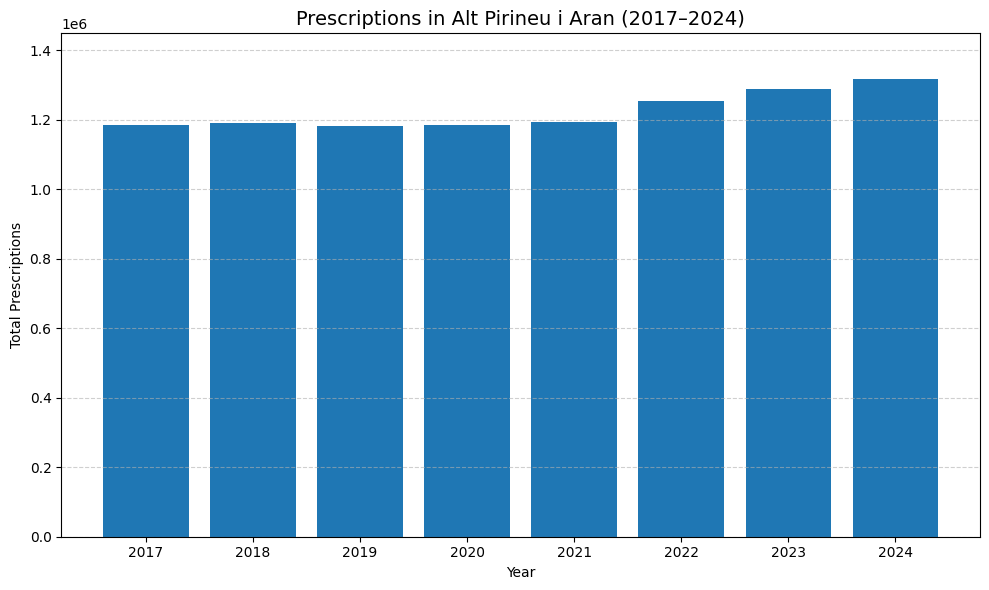

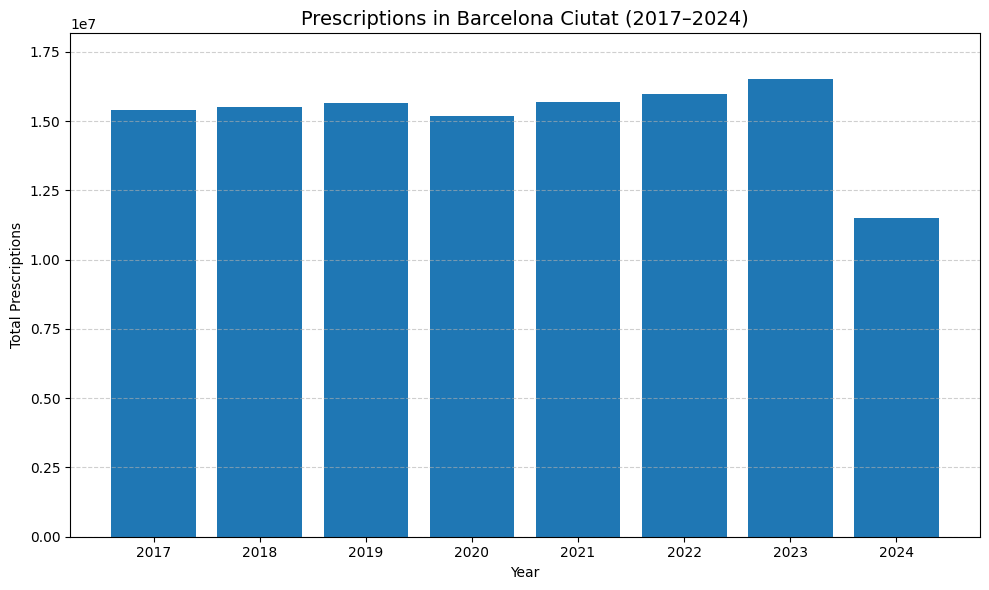

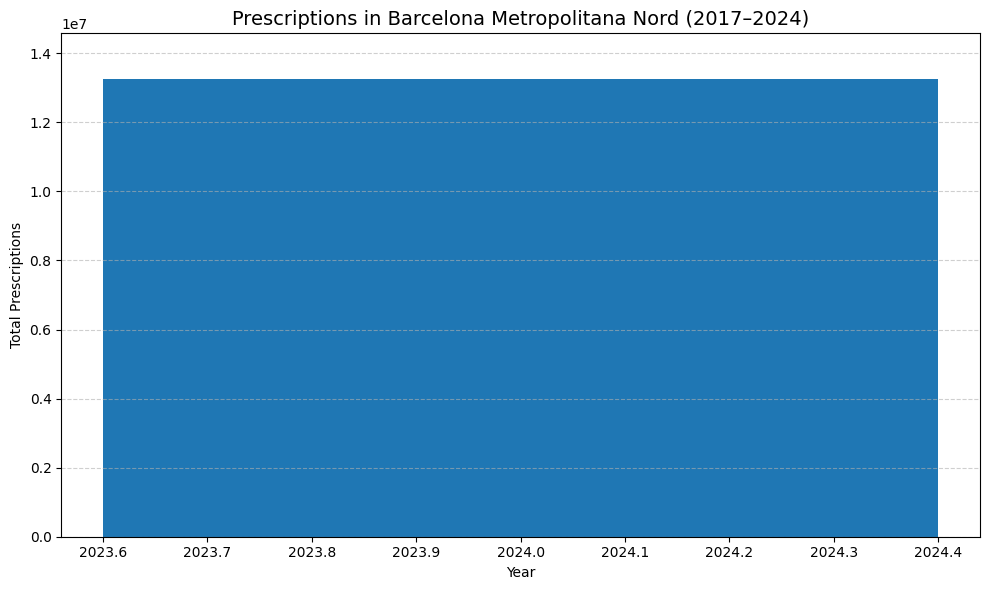

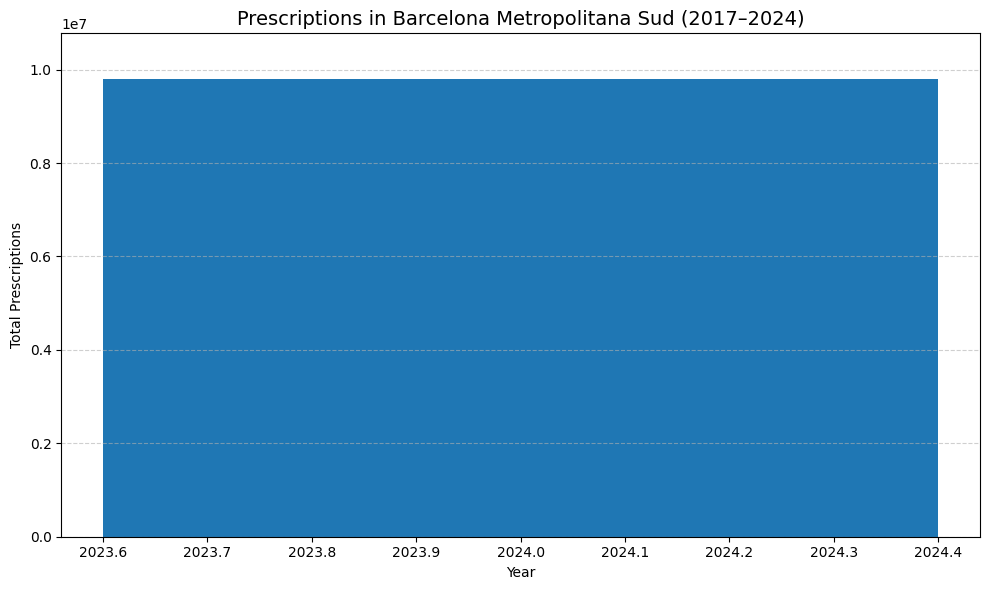

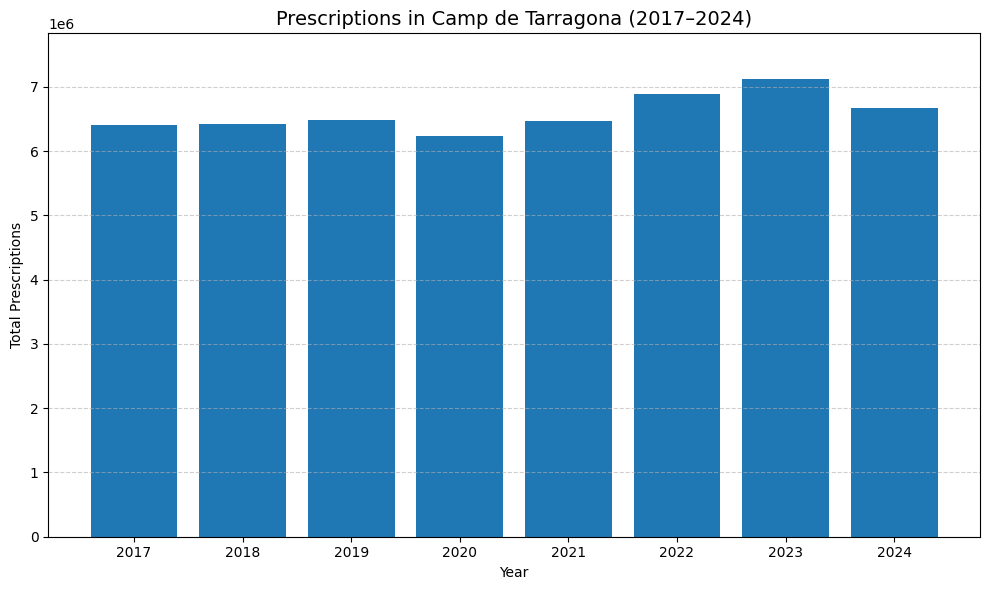

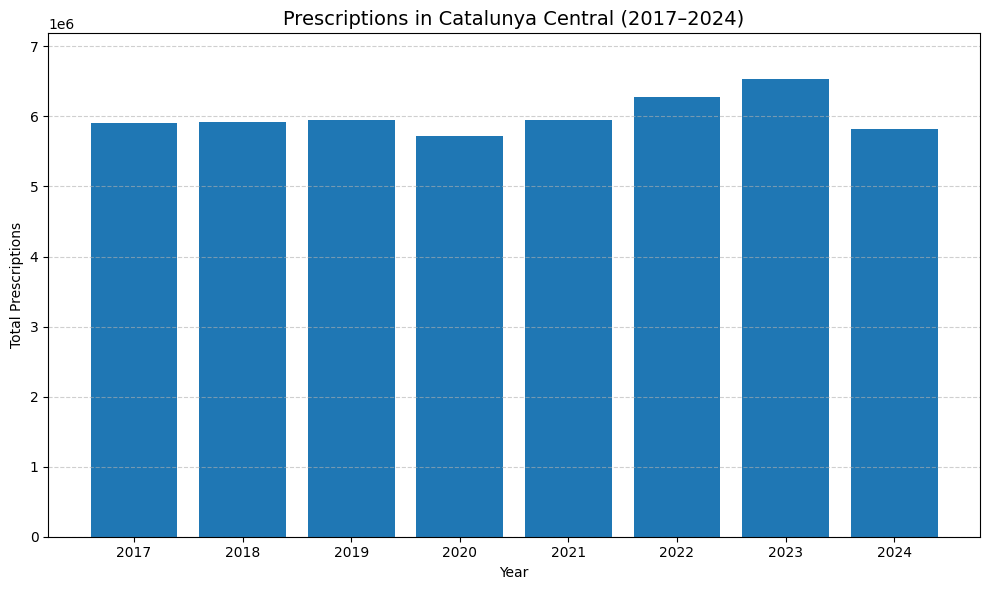

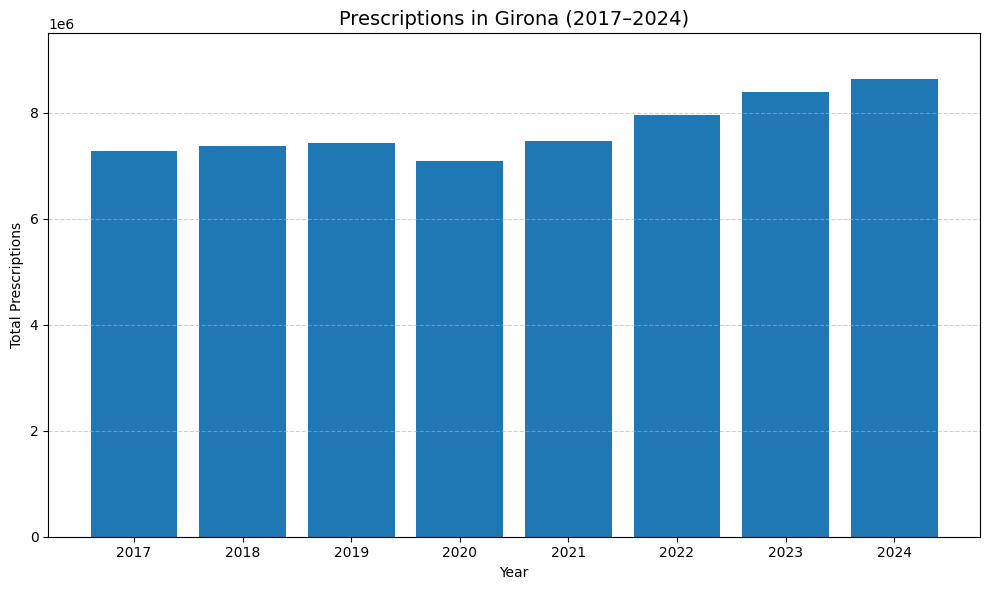

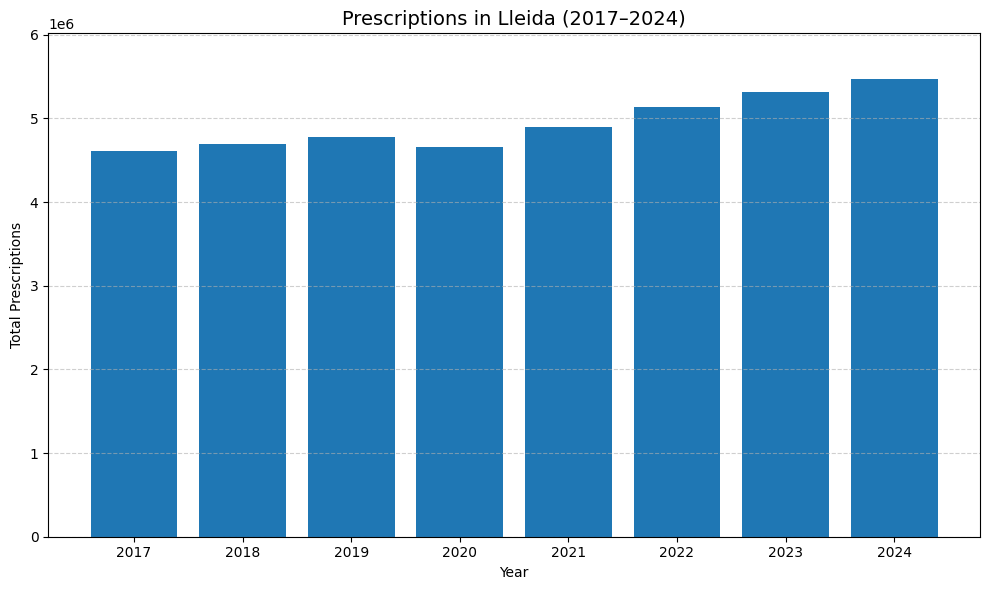

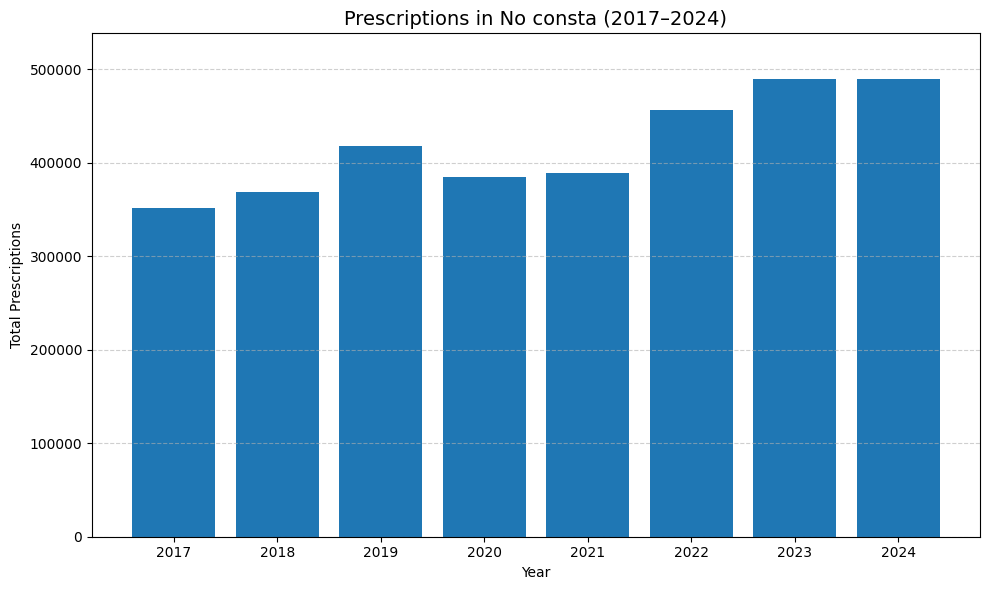

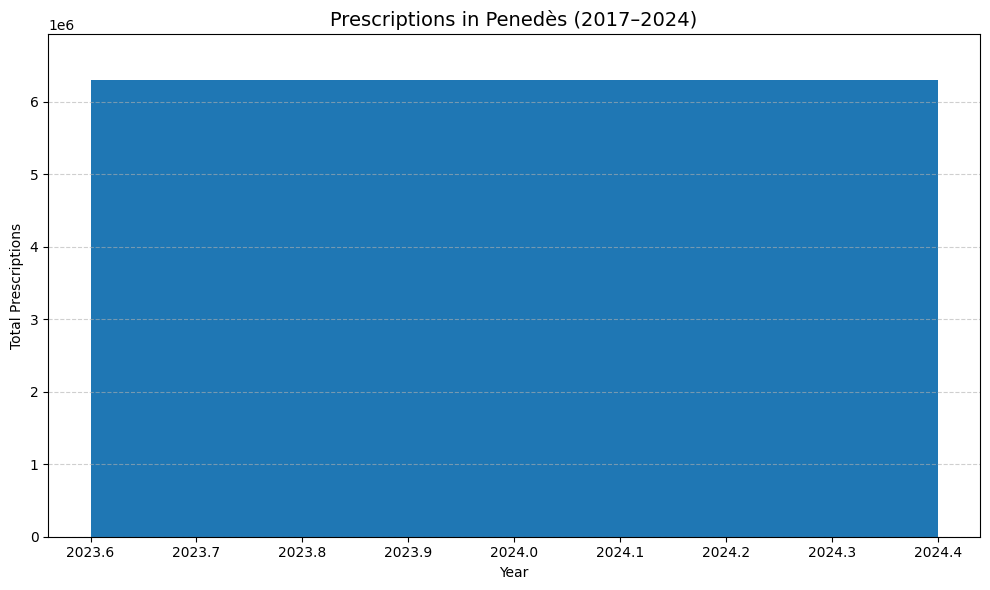

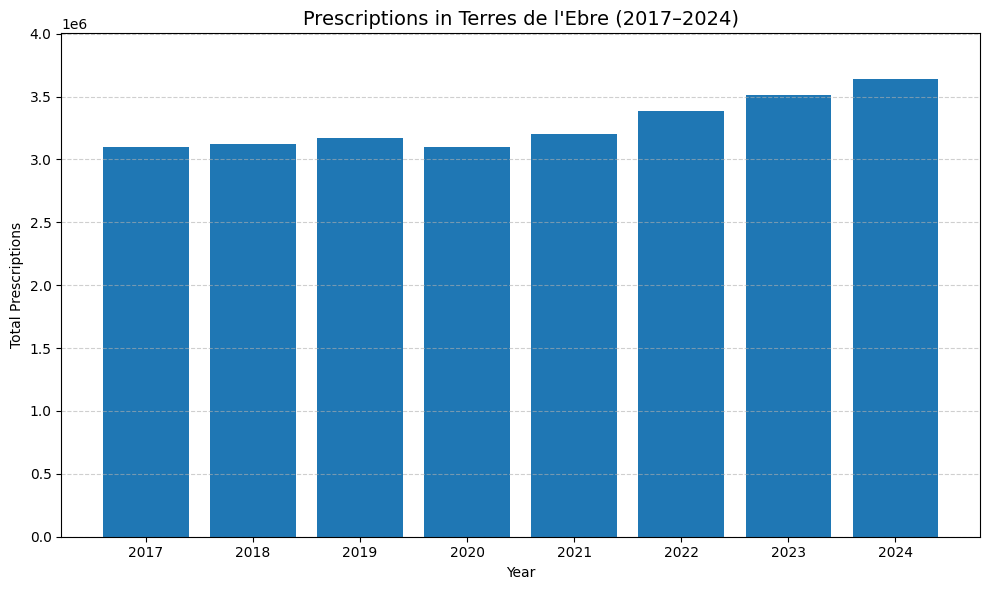

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Load dataset
# -------------------------------------------------
df = pd.read_csv("Dataset.csv", encoding="latin-1")

# Fix column encoding issue
df = df.rename(columns={'regiÃ³ sanitÃ ria': 'regió sanitària'})

# -------------------------------------------------
# 2. Region standardization
# -------------------------------------------------
region_mapping = {
    'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
    'ALTRES': 'No consta',
    'BARCELONA': 'Barcelona Ciutat',
    'BARCELONA CIUTAT': 'Barcelona Ciutat',
    'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
    'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
    'CAMP DE TARRAGONA': 'Camp de Tarragona',
    'CATALUNYA CENTRAL': 'Catalunya Central',
    'GIRONA': 'Girona',
    'LLEIDA': 'Lleida',
    'PENEDÈS': 'Penedès',
    'PENEDÃ\x88S': 'Penedès',
    'SENSE ESPECIFICAR': 'No consta',
    "TERRES DE L'EBRE": "Terres de l'Ebre"
}

df['regió sanitària'] = df['regió sanitària'].map(
    lambda x: region_mapping[x] if x in region_mapping else x
)
df = df.groupby(['regió sanitària', 'any'], as_index=False)['nombre de receptes'].sum()
print("\nRegions found:", sorted(df['regió sanitària'].dropna().unique()))

# -------------------------------------------------
# 3. Filter years
# -------------------------------------------------
df = df[(df['any'] >= 2017) & (df['any'] <= 2024)]


# -------------------------------------------------
# 4. Get a list of unique regions
# -------------------------------------------------
regions = sorted(df['regió sanitària'].dropna().unique())
print("\nPlotting regions:", regions)


# -------------------------------------------------
# 5. Loop through regions and plot bar charts
# -------------------------------------------------
for region in regions:

    df_region = df[df['regió sanitària'] == region].copy()

    if df_region.empty:
        continue

    yearly_series = (
        df_region.groupby('any')['nombre de receptes']
        .sum()
        .reset_index()
        .sort_values('any')
    )

    # ---- Bar plot ----
    plt.figure(figsize=(10, 6))
    plt.bar(
        yearly_series['any'],
        yearly_series['nombre de receptes']
    )

    plt.title(f"Prescriptions in {region} (2017–2024)", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Total Prescriptions")
    plt.ylim(0, yearly_series['nombre de receptes'].max() * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

